In [1]:
import ergo
import numpyro.distributions as dist
from scipy import stats
from seaborn import jointplot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/nix/Dropbox/Projects/Ergo/ergo/ergo/ppl.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Generating correlated samples from distributions with known density functions

It is fairly easy to generated correlated samples from two distributions if we can easily calculate the ppf function.  To do this we generate samples from a copula (a correlated multivariate distribution such that every marginal is uniform) and then we trasnform each dimension of the sample according to the ppf.  For a detailed explanation, I reccomend [this](https://twiecki.io/blog/2018/05/03/copulas/) simple blog post or [this](https://www.mathworks.com/help/stats/simulating-dependent-random-variables-using-copulas.html) more detailed explanation.

In [2]:
def correlated_distributions(ppf1, ppf2, corr):
    """
    Generate two correlated ergo distributions
    
    :param dist1: scipy distribution with .ppf function
    :param dist2: scipy distribution with .ppf function
    :corr: correlation coefficient for underlying normal distribution
    """
    
    corr_norm = ergo.ppl.sample(dist.MultivariateNormal(0, covariance_matrix=[[1,corr], [corr,1]]))
    corr_unif = stats.norm().cdf(corr_norm)
    x = ppf1(corr_unif[0])
    y = ppf2(corr_unif[1])
    return x, y

This can be used to generate correlated samples from any of the common distributions.

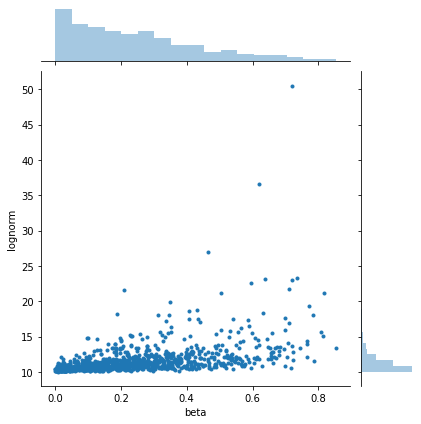

In [3]:
def ex_model():
    x, y = correlated_distributions(stats.beta(1,3).ppf, stats.lognorm(1, 10).ppf, corr=.6)
    ergo.tag(x, "beta")
    ergo.tag(y, "lognorm")
    
df = ergo.run(ex_model, 1000)
jointplot(df.beta, df.lognorm, marker=".")

This could pretty eaisily be extended to support other copulas and higher dimensions.

The current interface of passing in scipy distributions is obviously super clunky.  While this can be improved, I haven't thought of a way to do this that fits with ergo, is intuitive, and isn't super complicated internally.

# Imposing correlations on general Ergo distributions

What if we want to impose a correlation between two parameters, but we can't easily explicitly describe their shape?  This would happen if the parameters are based on a estimate using Ergo or from a metaculus community distribution, for example.

Recall all we need is the ppf.  While we might not know it explictly, we can approximate it!

In [4]:
def approximate_ppf(samples):
    """Takes a collection of samples and returns an approximated ppf."""
    return lambda q: np.percentile(samples, q*100)

def correlate_distributions(samples1, samples2, corr):
    """Creates a distribution with a given correlation  new distributions with the same shape as the original distributions, but associated by the given
    correlation constant."""
    return correlated_distributions(approximate_ppf(samples1), approximate_ppf(samples2), corr)

This is a simple example of correlating a ergo-calculated bimodal distribution with a distribution from guesstimate.

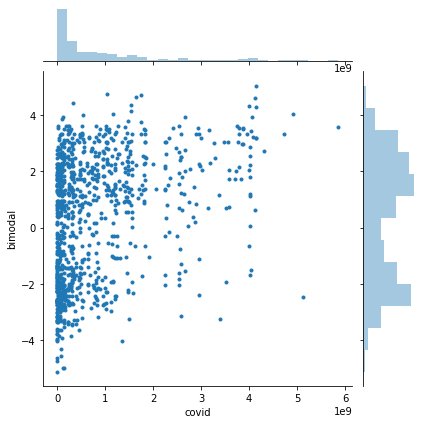

In [21]:
metaculus = ergo.Metaculus()

# Model the economic indicator:

def binary():
    return ergo.flip(.6)

def bimodal():
    b = binary()
    ergo.tag(b, "binary")
    if b:
        return ergo.normal(2,1)
    else:
        return ergo.normal(-2,1)

def covid_cases():
    return metaculus.get_question(3529).sample_community()

# generate samples:

covid_samples = ergo.run(covid_cases, 100).output
bimodal_samples = ergo.run(bimodal, 1000).output


def get_correlated_dists():
    x, y = correlate_distributions(covid_samples, bimodal_samples, corr=.4)
    ergo.tag(x, "covid")
    ergo.tag(y, "bimodal")
    
df = ergo.run(get_correlated_dists, 1000)
jointplot(df.covid, df.bimodal, marker=".")

For some intuition, we could say that the binary variable represents the winner of the 2020 presidential race and the bimodal variable is some economic indicator.  We have different expectations for the indicator based on the president, but also expect that will be correlated with how bad covid is.

One important thing to note is that if we draw a sample from the correlated economic indicator distribution, we no longer have a way to determine what the value of the binary variable was (who the chosen presidential-winner was).  We are only basing the correlated variable on the pdf, not the distribution that generated it.

## Multi-dimensional Sample Objects

One way to fix this is to use a Samples object that allows for a distribution over multiple values from the model.

Obviously the implementation below is a little sketchy and there are many things about the interface and such that can be improved.

In [23]:
class Samples:
    def __init__(self, output, name, iterations=5000, other_cols = []):
        """Creates a Samples object which saves the distribution over output,
        along with any other variables which are given in the list other_cols."""
        df = ergo.run(output, iterations)
        
        self.name = name
        self.samples = pd.DataFrame()
        self.samples[name] = df["output"]
        for col in other_cols:
            self.samples[col] = df[col]
    
    def ppf(self, q):
        """Returns a random sample with the appropriate ppf"""
        output_values = self.samples[self.name]
        value = np.percentile(output_values, 100*q, interpolation="nearest")
        return self.samples[output_values == value].sample()
    
    @staticmethod
    def correlated_sample(sample1, sample2, corr):
        """Returns a sample from a multivariate distribution where sample1.output and sample2.output
        are associated with the given correlation.  The sample is returned as a dictonary and includes
        any other columns that exist in the Samples objects."""
        corr_norm = ergo.ppl.sample(dist.MultivariateNormal(0, covariance_matrix=[[1,corr], [corr,1]]))
        corr_unif = stats.norm().cdf(corr_norm)
        
        # x and y are both single row panda dfs
        x = sample1.ppf(corr_unif[0])
        y = sample2.ppf(corr_unif[1])
        
        sample = {}
        for col in x.columns:
            sample[col] = x[col].iat[0]
        for col in y.columns:
            sample[col] = y[col].iat[0]
        
        return sample

Note that the current implimentaiton only samples from points that were actually in the joint distribution that makes it up.  In a one dimensional case it is easy to interpolate the ppf so that the distribution is smooth, instead of just returning an original element of the original samples.  It's not immediately clear to me how to do that well for multi-dimensional distributions, or if it's needed.

We can recreate the same model.

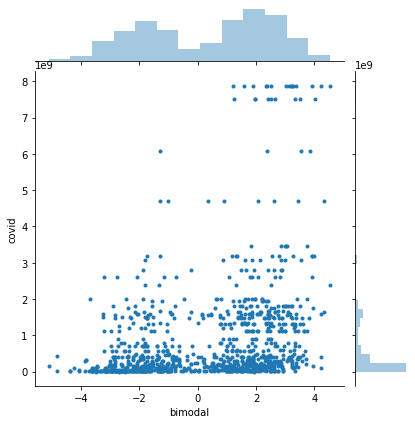

In [26]:
bimodal_sample_obj = Samples(bimodal, "bimodal", iterations=1000, other_cols=["binary"])
covid_sample_obj = Samples(covid_cases, "covid", iterations=100)

def joint_sample():
    sample =  Samples.correlated_sample(bimodal_sample_obj, covid_sample_obj, .4)
    ergo.tag(sample["bimodal"], "bimodal")
    ergo.tag(sample["binary"], "binary")
    ergo.tag(sample["covid"], "covid")

df = ergo.run(joint_sample, 1000)
jointplot(df.bimodal, df.covid, marker=".")

This implementation allows us to get the corresponding value of the binary variable for any sample from the bimodal variable.  However, note that correlation can introduce some strange effects as the binary variable is now also associated with covid cases, perhaps unintentionally!  For example, it could be the case that both the winner of the presidential race and the near term covid cases effect the economic variable, but the presential winner and the covid cases should be independant of each other.

This example underscores a general point -- if there is a clear direction of causality, it's probalby better to build that into the model rather than to use correlations.  It maybe also is a reason to not give users access to these variables after creating the correlated distributions.  

### Empirical Distributions

The idea of a Sample object is very close to the idea of a `EmpiricalDistribution` discussed in [issue #128](https://github.com/oughtinc/ergo/issues/128).  I think something closer to that would be the best way to make a change like this.

I'm not sure if such a change is a good idea.  It makes Ergo somewhat more complicated: the difference between functions that sample from distributions (e.g. `ergo.normal`) and distribution objects (e.g. `EmpiricalDistribution`) is somewhat subtle and could be confusing to users.  Using correlated distributions in the middle of a model is still somewhat confusing here, as you need to go from sampling functions -> empirical distributions -> a correlated joint distribution -> sampling functions.  But that does well represent what is required to perform the calculations.

I think the change would have lots of other advantages too!  It seems like a natural place to put functions related to visualizations, submission to metaculus, perhaps saving the model to be reused later, etc.  It could be an intuitive way to cache an expensive sub-step of a model (eg. pulling a 1000 samples from Metaculus) if you are tweaking an running the model many times in a row.  It would also allow for variance reduction techniques to be used during the sampling process itself -- although I personally don't understand these in detail.

# Future Directions / Next steps

Here are some possible solutions that might make sense, from easiest to hardest.

 - Add an example notebook demonstrating how to do correlated distributions to ergo using copulas as in the first part of this notebook.  Don't add anything to the codebase.
 - Add some utility functions that make it somewhat easier to add correlated distributions.  E.g. a function `correlate(distributions or samples, corr_coeff, copula)` which returns a tuple of corresponding values. This function would behave somewhat differently from the rest of the codebase -- for instance, requiring samples to be passed in.  It would also make the distribution's samples independant from the previous steps of the model.
 - Add an Empirical_Distribution object that could be used instead of `run`.  Add support for correlations using that.
   - Either built to exist alongside `run` or to eventual replace it entirely.
   - Could be as simple as an object that gives a home for operations that act on collections of samples.  Or it could  incorporate variance reduction techniques.
   
   
My thoughts: I like the idea of Empirical Distributions for reasons that have nothing to do with correlations.  If EDs are going to be added anyway, it's a more intuitive way to build in support for correlations. I don't think they seem worth it to add only for this purpose -- it's a lot of complexity without a good enough reason.

Otherwise, I think I'd weakly-lean towards the middle option of giving them support in the code-base over just having them as an example in a notebook or in the documentation.